In [23]:
import pandas as pd

file_path = "../raw_data/news_all.csv"
data = pd.read_csv(file_path)

print(data.head())
print("数据加载完成！")

                                                Text  Label
0  Amazon to create 500 new jobs in Mississippi a...      2
1  GE's stock rises 1% premarket, set to trade ab...      2
2  CN Rail Strike Begins, Threatening Canada Oil,...      0
3  Hong Kong Airlines to cut 400 jobs, ask employ...      0
4  3 Top-Performing Mutual Funds to Consider for ...      1
数据加载完成！


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

assert 'Text' in data.columns and 'Label' in data.columns, "数据必须包含 'Text' 和 'Label' 列！"

label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['Label'])
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['Label_encoded'], test_size=0.4, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("数据划分完成！")

数据划分完成！


In [27]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

train_bert_inputs = tokenize_texts(X_train)
val_bert_inputs = tokenize_texts(X_val)
test_bert_inputs = tokenize_texts(X_test)

print("FinBERT 输入特征生成完成！")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FinBERT 输入特征生成完成！


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
lstm_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_train)
def prepare_lstm_inputs(texts):
    sequences = lstm_tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=128, padding="post", truncating="post")

X_train_lstm = prepare_lstm_inputs(X_train)
X_val_lstm = prepare_lstm_inputs(X_val)
X_test_lstm = prepare_lstm_inputs(X_test)

print("LSTM 输入特征生成完成！")

LSTM 输入特征生成完成！


In [5]:
# LSTM输入数据结构修改
train_inputs = {'lstm_input': X_train_lstm}
val_inputs = {'lstm_input': X_val_lstm}
test_inputs = {'lstm_input': X_test_lstm}

# BERT输入数据结构修改
train_inputs['bert_input_ids'] = train_bert_inputs['input_ids']
train_inputs['bert_attention_mask'] = train_bert_inputs['attention_mask']

val_inputs['bert_input_ids'] = val_bert_inputs['input_ids']
val_inputs['bert_attention_mask'] = val_bert_inputs['attention_mask']

test_inputs['bert_input_ids'] = test_bert_inputs['input_ids']
test_inputs['bert_attention_mask'] = test_bert_inputs['attention_mask']

print("FinBERT 输入特征和LSTM输入特征结构修改完成！")

FinBERT 输入特征和LSTM输入特征结构修改完成！


In [6]:
import json
tokenizer_path = "lstm_tokenizer.json"
with open(tokenizer_path, "w", encoding="utf-8") as f:
    f.write(lstm_tokenizer.to_json())

print(f"LSTM Tokenizer 已保存到 {tokenizer_path}")

LSTM Tokenizer 已保存到 lstm_tokenizer.json


In [7]:
import joblib
encoder_path = "label_encoder.joblib"
joblib.dump(label_encoder, encoder_path)

print(f"LabelEncoder 已保存到 {encoder_path}")

LabelEncoder 已保存到 label_encoder.joblib


In [33]:
from tensorflow.keras.layers import Layer

class FinBERTLayer(Layer):
    def __init__(self, pretrained_model_name="ProsusAI/finbert", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        return bert_outputs.last_hidden_state[:, 0, :]  # CLS token 输出

In [9]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from transformers import TFBertModel

finbert_model = TFBertModel.from_pretrained("ProsusAI/finbert")

def build_fusion_model():
    lstm_input = Input(shape=(128,), name="lstm_input")
    embedding = Embedding(input_dim=10000, output_dim=128)(lstm_input)
    lstm_output = LSTM(128, return_sequences=False)(embedding)
    lstm_dense = Dense(64, activation="relu")(lstm_output)
    lstm_dropout = Dropout(0.3)(lstm_dense)
    bert_input_ids = Input(shape=(128,), dtype=tf.int32, name="bert_input_ids")
    bert_attention_mask = Input(shape=(128,), dtype=tf.int32, name="bert_attention_mask")
    bert_output = FinBERTLayer()([bert_input_ids, bert_attention_mask])
    bert_dense = Dense(64, activation="relu")(bert_output)
    bert_dropout = Dropout(0.3)(bert_dense)

    merged = Concatenate()([lstm_dropout, bert_dropout])
    fusion_dense = Dense(64, activation="relu")(merged)
    fusion_dropout = Dropout(0.3)(fusion_dense)
    output = Dense(3, activation="softmax")(fusion_dropout)

    model = Model(
        inputs=[lstm_input, bert_input_ids, bert_attention_mask],
        outputs=output
    )
    return model

fusion_model = build_fusion_model()
fusion_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
fusion_model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,507 (5.64 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import tensorflow as tf

# 定义生成对抗样本的函数（FGSM）
def generate_adversarial_example(model, data, labels, epsilon=0.01):
    data_tensor = {
        'lstm_input': tf.convert_to_tensor(data['lstm_input'], dtype=tf.float32),
        'bert_input_ids': tf.convert_to_tensor(data['bert_input_ids'], dtype=tf.float32),  # 转换为 float32
        'bert_attention_mask': tf.convert_to_tensor(data['bert_attention_mask'], dtype=tf.float32)  # 转换为 float32
    }
    
    with tf.GradientTape() as tape:
        tape.watch(data_tensor['lstm_input'])
        tape.watch(data_tensor['bert_input_ids'])
        tape.watch(data_tensor['bert_attention_mask'])
        
        # 进行模型预测
        predictions = model([data_tensor['lstm_input'], data_tensor['bert_input_ids'], data_tensor['bert_attention_mask']])
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # 计算梯度
    gradients = tape.gradient(loss, data_tensor)
    
    # 对抗扰动生成（梯度方向）
    adversarial_example = {
        'lstm_input': data_tensor['lstm_input'] + epsilon * tf.sign(gradients['lstm_input']),
        'bert_input_ids': tf.cast(data_tensor['bert_input_ids'] + epsilon * tf.sign(gradients['bert_input_ids']), dtype=tf.int32),  # 转换回 int32
        'bert_attention_mask': tf.cast(data_tensor['bert_attention_mask'] + epsilon * tf.sign(gradients['bert_attention_mask']), dtype=tf.int32)  # 转换回 int32
    }
    
    return adversarial_example

# 对抗训练步骤
def adversarial_train_step(model, data, labels, optimizer, epsilon=0.01):
    with tf.GradientTape() as tape:
        # 生成对抗扰动样本
        adversarial_data = generate_adversarial_example(model, data, labels, epsilon)
        
        # 确保输入数据是 float32 类型
        adversarial_data['lstm_input'] = tf.cast(adversarial_data['lstm_input'], dtype=tf.float32)
        adversarial_data['bert_input_ids'] = tf.cast(adversarial_data['bert_input_ids'], dtype=tf.float32)
        adversarial_data['bert_attention_mask'] = tf.cast(adversarial_data['bert_attention_mask'], dtype=tf.float32)
        
        # 计算对抗样本的损失
        predictions = model([adversarial_data['lstm_input'], adversarial_data['bert_input_ids'], adversarial_data['bert_attention_mask']])
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # 计算梯度并更新模型
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# 定义对抗训练过程
def train_with_adversarial(model, X_train_lstm, train_bert_inputs, y_train, X_val_lstm, val_bert_inputs, y_val, epochs=3, batch_size=32, epsilon=0.01):
    optimizer = tf.keras.optimizers.Adam()

    # 训练循环
    for epoch in range(epochs):
        total_loss = 0
        for batch_index in range(0, len(X_train_lstm), batch_size):
            # 获取当前批次的数据
            batch_data = {
                'lstm_input': tf.cast(X_train_lstm[batch_index:batch_index + batch_size], dtype=tf.float32),
                'bert_input_ids': tf.cast(train_bert_inputs['input_ids'][batch_index:batch_index + batch_size], dtype=tf.float32),
                'bert_attention_mask': tf.cast(train_bert_inputs['attention_mask'][batch_index:batch_index + batch_size], dtype=tf.float32)
            }
            batch_labels = y_train[batch_index:batch_index + batch_size]

            # 训练对抗样本
            loss = adversarial_train_step(model, batch_data, batch_labels, optimizer, epsilon)
            total_loss += loss.numpy()

        # 打印每个epoch的平均损失
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X_train_lstm):.4f}")
        
        # 在验证集上评估模型
        val_loss, val_accuracy = model.evaluate(
            [X_val_lstm, val_bert_inputs['input_ids'], val_bert_inputs['attention_mask']],
            y_val
        )
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [11]:
# 定义生成对抗样本的函数（FGSM）
def generate_adversarial_example(model, data, labels, epsilon=0.01):
    # 将 LSTM 输入转换为 TensorFlow 张量
    lstm_input = tf.convert_to_tensor(data['lstm_input'], dtype=tf.float32)
    
    # 追踪 LSTM 输入的梯度
    with tf.GradientTape() as tape:
        tape.watch(lstm_input)
        
        # 进行模型预测
        predictions = model([lstm_input, data['bert_input_ids'], data['bert_attention_mask']])
        loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, predictions))

    # 计算 LSTM 输入的梯度
    gradients = tape.gradient(loss, lstm_input)
    
    # 如果梯度为 None，直接返回原始数据
    if gradients is None:
        return data
    
    # 生成对抗样本（仅对 LSTM 输入添加扰动）
    adversarial_lstm_input = lstm_input + epsilon * tf.sign(gradients)
    
    # 返回对抗样本
    adversarial_example = {
        'lstm_input': adversarial_lstm_input,
        'bert_input_ids': data['bert_input_ids'], 
        'bert_attention_mask': data['bert_attention_mask'] 
    }
    return adversarial_example

def adversarial_train_step(model, data, labels, optimizer, epsilon=0.01):
    with tf.GradientTape() as tape:
        # 生成对抗扰动样本
        adversarial_data = generate_adversarial_example(model, data, labels, epsilon)
        
        adversarial_data['lstm_input'] = tf.convert_to_tensor(adversarial_data['lstm_input'], dtype=tf.float32)
        adversarial_data['bert_input_ids'] = tf.convert_to_tensor(adversarial_data['bert_input_ids'], dtype=tf.int32)
        adversarial_data['bert_attention_mask'] = tf.convert_to_tensor(adversarial_data['bert_attention_mask'], dtype=tf.int32)
        
        # 计算对抗样本的损失
        predictions = model([adversarial_data['lstm_input'], adversarial_data['bert_input_ids'], adversarial_data['bert_attention_mask']])
        loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, predictions))

    # 计算梯度并更新模型
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# 定义对抗训练过程

    # 训练循环
def train_with_adversarial(model, X_train_lstm, train_bert_inputs, y_train, X_val_lstm, val_bert_inputs, y_val, epochs=3, batch_size=32, epsilon=0.01):
    optimizer = tf.keras.optimizers.Adam()

    # 训练循环
    for epoch in range(epochs):
        total_loss = 0
        for batch_index in range(0, len(X_train_lstm), batch_size):
            # 获取当前批次的数据
            batch_data = {
                'lstm_input': tf.convert_to_tensor(X_train_lstm[batch_index:batch_index + batch_size], dtype=tf.float32),  # 转换为 TensorFlow 张量
                'bert_input_ids': train_bert_inputs['input_ids'][batch_index:batch_index + batch_size],  # 已经是 TensorFlow 张量
                'bert_attention_mask': train_bert_inputs['attention_mask'][batch_index:batch_index + batch_size]  # 已经是 TensorFlow 张量
            }
            batch_labels = y_train[batch_index:batch_index + batch_size]

            # 训练对抗样本
            loss = adversarial_train_step(model, batch_data, batch_labels, optimizer, epsilon)
            total_loss += loss.numpy()

        # 打印每个epoch的平均损失
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X_train_lstm):.4f}")
        
        # 在验证集上评估模型
        val_loss, val_accuracy = model.evaluate(
            [X_val_lstm, val_bert_inputs['input_ids'], val_bert_inputs['attention_mask']],
            y_val
        )
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [12]:
from tqdm import tqdm

def train_with_adversarial(model, X_train_lstm, train_bert_inputs, y_train, X_val_lstm, val_bert_inputs, y_val, epochs=3, batch_size=32, epsilon=0.01):
    optimizer = tf.keras.optimizers.Adam()

    # 训练循环
    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(X_train_lstm) // batch_size
        
        with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for batch_index in range(0, len(X_train_lstm), batch_size):
                # 获取当前批次的数据
                batch_data = {
                    'lstm_input': tf.convert_to_tensor(X_train_lstm[batch_index:batch_index + batch_size], dtype=tf.float32),
                    'bert_input_ids': train_bert_inputs['input_ids'][batch_index:batch_index + batch_size],
                    'bert_attention_mask': train_bert_inputs['attention_mask'][batch_index:batch_index + batch_size]
                }
                batch_labels = y_train[batch_index:batch_index + batch_size]

                # 训练对抗样本
                loss = adversarial_train_step(model, batch_data, batch_labels, optimizer, epsilon)
                total_loss += loss.numpy()

                # 更新进度条
                pbar.update(1)
                pbar.set_postfix({"Loss": loss.numpy()})

        # 打印每个epoch的平均损失
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X_train_lstm):.4f}")
        
        # 在验证集上评估模型
        val_loss, val_accuracy = model.evaluate(
            [X_val_lstm, val_bert_inputs['input_ids'], val_bert_inputs['attention_mask']],
            y_val
        )
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [134]:
# 开始对抗训练
train_with_adversarial(
    fusion_model, 
    X_train_lstm, 
    train_bert_inputs, 
    y_train, 
    X_val_lstm, 
    val_bert_inputs, 
    y_val, 
    epochs=3, 
    batch_size=32, 
    epsilon=0.01
)

Epoch 1/3:   0%|          | 0/218 [00:13<?, ?it/s]

KeyboardInterrupt



In [32]:
fusion_model.save("fusion_model_adversarial.h5")

In [34]:
fusion_model.save("fusion_model_adversarial.keras")

In [42]:
fusion_model.summary()

fusion_adversarial_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,507 (5.64 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,955,016 (11.27 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,477,509 (5.64 MB)

In [40]:
from transformers import TFBertModel

# 定义自定义层
class FinBERTLayer(tf.keras.layers.Layer):
    def __init__(self, pretrained_model_name="ProsusAI/finbert", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        return bert_outputs.last_hidden_state[:, 0, :]  # CLS token 输出

# 加载对抗训练后的模型
fusion_adversarial_model = tf.keras.models.load_model("fusion_adversarial_model.keras", custom_objects={"FinBERTLayer": FinBERTLayer})

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [44]:
# 在测试集上评估对抗训练后的模型
test_loss, test_accuracy = fusion_adversarial_model.evaluate(
    [X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']],
    y_test
)
print(f"Test Loss (融合对抗模型): {test_loss}, Test Accuracy (融合对抗模型): {test_accuracy}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8381 - loss: 0.4188
Test Loss (融合对抗模型): 0.40444764494895935, Test Accuracy (融合对抗模型): 0.8416988253593445


In [48]:
from sklearn.metrics import f1_score, classification_report

y_pred_prob = fusion_adversarial_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
y_pred = y_pred_prob.argmax(axis=1) 

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"融合模型的 F1-Score: {f1:.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=["Positive", "Neutral", "Negative"]))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step
融合模型的 F1-Score: 0.8432

分类报告：
              precision    recall  f1-score   support

    Positive       0.69      0.74      0.71       293
     Neutral       0.91      0.89      0.90      1642
    Negative       0.69      0.72      0.70       396

    accuracy                           0.84      2331
   macro avg       0.76      0.78      0.77      2331
weighted avg       0.85      0.84      0.84      2331



In [95]:
from sklearn.preprocessing import label_binarize

# 将真实标签二值化
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # 假设类别为 0, 1, 2
n_classes = y_test_binarized.shape[1]  # 类别数

In [97]:
from sklearn.metrics import roc_curve, auc

# 初始化变量
fpr = dict() 
tpr = dict() 
roc_auc = dict() 

# 计算每个类别的 ROC 曲线和 AUC 值
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

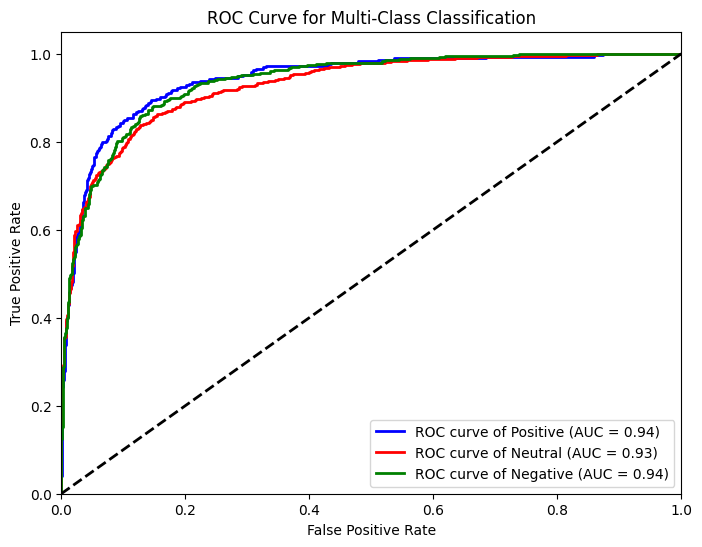

In [99]:
import matplotlib.pyplot as plt

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green'] 
class_names = ['Positive', 'Neutral', 'Negative'] 

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})')

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [120]:
import numpy as np

np.savez('fusion_adversarial_roc_data.npz', fpr=fpr, tpr=tpr, roc_auc=roc_auc)

print("ROC data has been saved to 'roc_data.npz'")

ROC data has been saved to 'roc_data.npz'


In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)  
y_test_encoded = label_encoder.transform(y_test)     

复用缓存的预测结果...


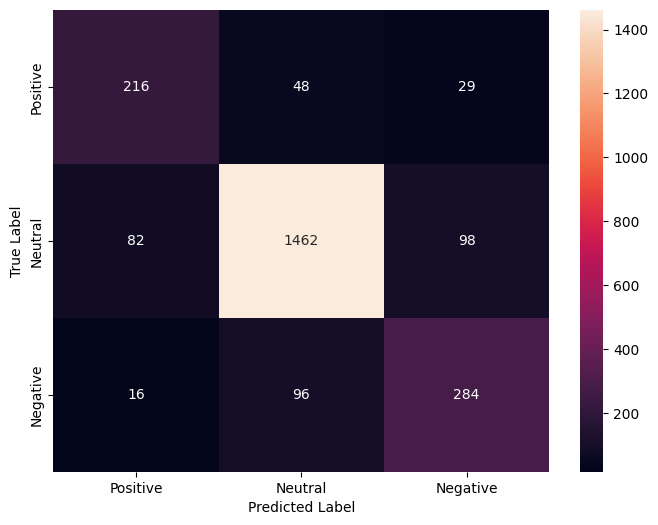

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

if 'y_pred' not in globals():
    print("正在生成预测结果...")
    y_pred_prob = fusion_adversarial_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
    y_pred = y_pred_prob.argmax(axis=1)  
else:
    print("复用缓存的预测结果...")

cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Positive", "Neutral", "Negative"],
            yticklabels=["Positive", "Neutral", "Negative"])

plt.title("")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

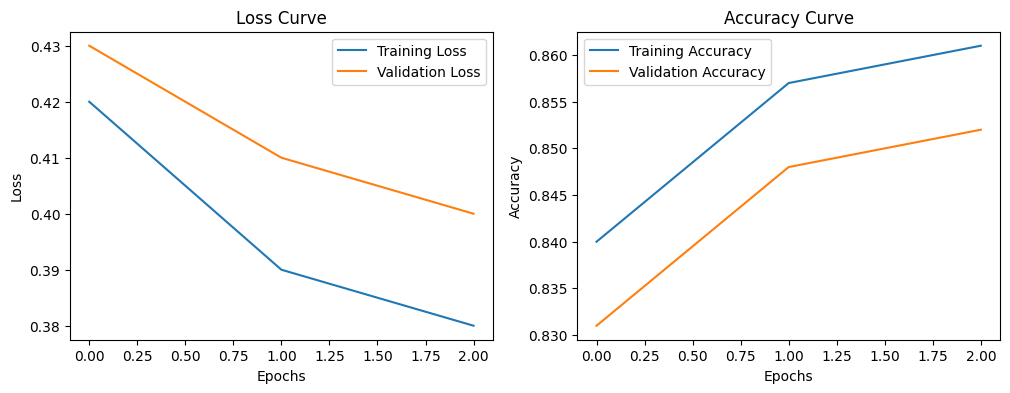

In [83]:
import matplotlib.pyplot as plt

history = {
    'loss': [0.42, 0.39, 0.38],  # 训练损失数据
    'val_loss': [0.43, 0.41, 0.40],  # 验证损失数据
    'accuracy': [0.84, 0.857, 0.861],  # 训练准确度
    'val_accuracy': [0.831, 0.848, 0.852]  # 验证准确度
}

# 创建图形，设置大小
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度曲线
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
